In [5]:
!pip install transformers
!pip install -U sacremoses
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [6]:

import torch
import pandas as pd

from keras.preprocessing.sequence import pad_sequences
from transformers import (
    AdamW,
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

from IPython import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### TRAIN

In [ ]:
df = pd.read_excel('/content/hackaton_result_dataset.xlsx')
df.shape

(6508, 4)

In [ ]:
category_index = {str(i[1]):int(i[0]) for i in enumerate(df.label.unique())}
category_index_reverce = {str(i[0]):int(i[1]) for i in enumerate(df.label.unique())}
category_index_reverce

{'0': 1, '1': 0}

In [ ]:
sentences = df.model_annotation.values
labels = df.label.values
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased-conversational')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://h

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([3.955e+03, 1.847e+03, 4.490e+02, 1.550e+02, 5.800e+01, 2.600e+01,
        8.000e+00, 4.000e+00, 3.000e+00, 3.000e+00]),
 array([ 3. ,  9.2, 15.4, 21.6, 27.8, 34. , 40.2, 46.4, 52.6, 58.8, 65. ]),
 <BarContainer object of 10 artists>)

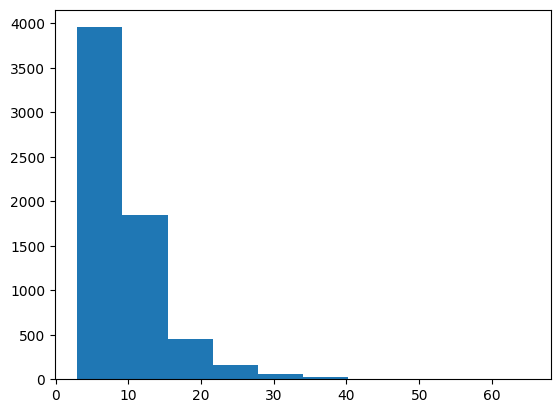

In [ ]:
lenths = [len(sent) for sent in tokenized_texts]
plt.hist(lenths)

In [ ]:
input_ids = pad_sequences(
    input_ids,
    maxlen=32,
    dtype='long',
    truncating='post',
    padding='post'
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
def to_ids(texts: list[str]) -> tuple[list[int], list[float]]:
  sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in texts]
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  input_ids = pad_sequences(
      input_ids,
      maxlen=32,
      dtype='long',
      truncating='post',
      padding='post'
  )

  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
  return torch.tensor(input_ids).to(device), torch.tensor(attention_masks).to(device)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids,
    labels,
    attention_masks,
    random_state=42,
    test_size=0.15
)

In [ ]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, labels, masks):
        self.input_ids = input_ids
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]).to(device),
            "attention_mask": torch.tensor(self.masks[idx]).to(device),
            "labels": torch.tensor(self.labels[idx]).to(device)
        }

train_dataset = TokenizedDataset(train_inputs, train_labels, train_masks)
eval_dataset = TokenizedDataset(validation_inputs, validation_labels, validation_masks)

In [ ]:
training_args = TrainingArguments(
    output_dir="data",
    num_train_epochs=10,
    learning_rate=5e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.1,
    logging_steps=25,
    eval_steps=25,
    save_steps=50,
    evaluation_strategy="steps",
    remove_unused_columns=True,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def get_metrics(eval_pred):
    label_ids = eval_pred.label_ids
    probs = eval_pred.predictions[:, 1]
    roc_auc = roc_auc_score(label_ids, probs)
    return {"roc_auc": roc_auc}

In [ ]:
config = AutoConfig.from_pretrained(
    'DeepPavlov/rubert-base-cased-conversational',
    num_labels=2,
    id2label=category_index_reverce,
    label2id=category_index
)
model = AutoModelForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased-conversational', config=config, device_map=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.dropout = torch.nn.Dropout(p=0.5)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=get_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
25,0.703800,0.684836,0.500340
50,0.677500,0.673965,0.566013
75,0.662300,0.667235,0.614106
100,0.665700,0.648853,0.705861
125,0.640000,0.616849,0.757331
150,0.605200,0.580367,0.778244
175,0.565100,0.574629,0.791796
200,0.534900,0.541500,0.799084
225,0.528600,0.530180,0.808414
250,0.498700,0.527810,0.814186


TrainOutput(global_step=600, training_loss=0.4940998125076294, metrics={'train_runtime': 607.9966, 'train_samples_per_second': 90.971, 'train_steps_per_second': 1.431, 'total_flos': 627815866970880.0, 'train_loss': 0.4940998125076294, 'epoch': 6.896551724137931})

In [ ]:
log_history = {}

for log in trainer.state.log_history:
  if log['step'] not in log_history:
    log_history[log['step']] = {}

  if 'loss' in log:
    log_history[log['step']]['train_loss'] = log['loss']
  if 'eval_loss' in log:
    log_history[log['step']]['eval_loss'] = log['eval_loss']
    log_history[log['step']]['eval_roc_auc'] = log['eval_roc_auc']

history = {
    'steps': [],
    'train_loss': [],
    'eval_loss': [],
    'eval_roc_auc': []
}

for step, values in log_history.items():
  history['steps'].append(step)
  if 'train_loss' in values:
    history['train_loss'].append(values['train_loss'])
  else:
    history['train_loss'].append(None)

  history['eval_loss'].append(values['eval_loss'])
  history['eval_roc_auc'].append(values['eval_roc_auc'])


In [ ]:
def plot_history(history):

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(history['steps'], history["train_loss"], "b", label="train_loss")
    plt.plot(history['steps'], history["eval_loss"], "r", label="eval_loss")
    plt.legend(loc="upper left")
    plt.title("Loss")


    plt.subplot(1, 2, 2)
    plt.plot(history['steps'], history["eval_roc_auc"], "b", label="eval_roc_auc")
    plt.legend(loc="upper left")
    plt.title("ROC AUC")

    display.display(plt.gcf())
    display.clear_output(wait=True)

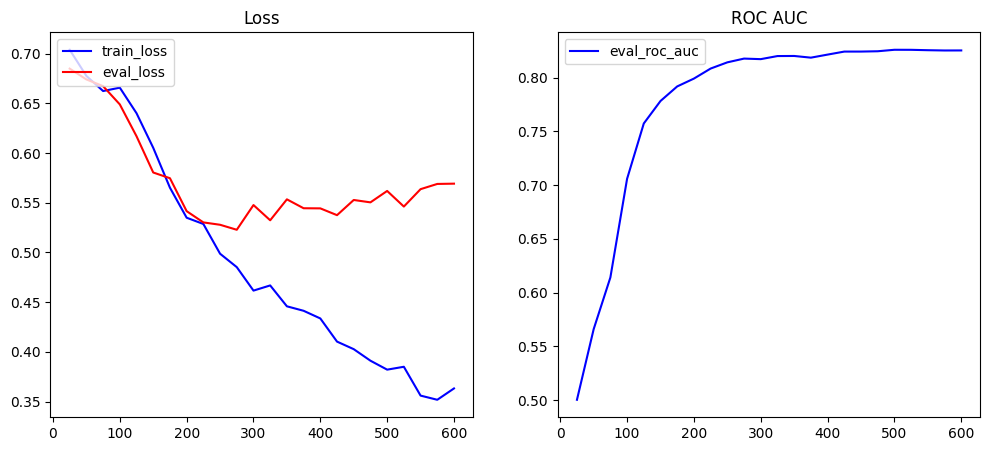

In [ ]:
plot_history(history)

In [ ]:
trainer.save_model("/content/best_model")

In [ ]:
def show_results(model, texts: list[str]) -> float:
  input_ids, masks = to_ids(texts)
  with torch.no_grad():

    predictions = model(input_ids, token_type_ids=None, attention_mask=masks)

  preds = predictions.logits.clone().detach().cpu().requires_grad_(False)
  preds = preds.argmax(-1)
  return [(text, int(preds[i])) for i, text in enumerate(texts)]

In [ ]:
def show_sample_comparison(n=20):
  samples = df.sample(n)[["model_annotation", "label"]]
  results = show_results(model, list(samples["model_annotation"]))
  eval_labels = [label for _, label in results]
  samples["eval_label"] = eval_labels
  return samples

In [ ]:
show_sample_comparison()

,model_annotation,label,eval_label
3393,нет я начальник первого отделения,0,0
5381,горки я вам ответил оплачиваете,1,1
4816,компания компан,1,1
3434,получается у вас говори все в порядке,1,0
96,более не существует но тем не менее,0,0
3357,краснознаменского района,1,0
4214,милицию нажал,1,1
5562,вы в каком отделе работаете,0,0
4724,ну и а что то ей говорил,1,0
3016,на улице все оху есть,1,0


In [ ]:
!zip -r /content/best_model.zip /content/best_model

In [ ]:
from google.colab import files
files.download("/content/best_model.zip")

### TEST

In [1]:
!gdown 1jF93RUNs9e1-Dbp3KbW32-OMnpxtAxZG

Downloading...
From (original): https://drive.google.com/uc?id=1jF93RUNs9e1-Dbp3KbW32-OMnpxtAxZG
From (redirected): https://drive.google.com/uc?id=1jF93RUNs9e1-Dbp3KbW32-OMnpxtAxZG&confirm=t&uuid=182680b2-6983-4533-9c90-e4a716eafe6c
To: /content/best_model.zip
100% 658M/658M [00:09<00:00, 66.7MB/s]


In [3]:
!unzip /content/best_model.zip

Archive:  /content/best_model.zip
   creating: content/best_model/
  inflating: content/best_model/tokenizer.json  
  inflating: content/best_model/tokenizer_config.json  
  inflating: content/best_model/vocab.txt  
  inflating: content/best_model/special_tokens_map.json  
  inflating: content/best_model/training_args.bin  
  inflating: content/best_model/config.json  
  inflating: content/best_model/model.safetensors  


In [9]:
tokenizer = AutoTokenizer.from_pretrained('/content/content/best_model')

config = AutoConfig.from_pretrained('/content/content/best_model')
model = AutoModelForSequenceClassification.from_pretrained('/content/content/best_model')

In [12]:
eval_df = pd.read_excel('/content/data_part1.xlsx')
eval_df.shape

(10000, 4)

In [13]:
eval_df.head()

,annotation_fastconformer,human_markup,audio_path,label
0,у нас здесь муж много,вот у нас здесь мух много,51b0fadce17e.wav,0
1,понимаешь если бы это был случай он тебя не бо...,понимаешь если бы это было случайно он бы тебя...,42e052ce1540.wav,0
2,вот как ты языков своих трепишь блять они еще ...,вот как ты языком своим треплешь блять они ещё...,42de1bfba887.wav,0
3,и согласен с тем что молчать нельзя и нужно об...,я согласен с тем что молчать нельзя и нужно об...,42dc265ff6f9.wav,0
4,грузинского информата,фрунзенского военкомата,42d97a9d47f1.wav,1


In [14]:
def to_ids(texts: list[str]) -> tuple[list[int], list[float]]:
  sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in texts]
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  input_ids = pad_sequences(
      input_ids,
      maxlen=32,
      dtype='long',
      truncating='post',
      padding='post'
  )

  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
  return torch.tensor(input_ids).to(device), torch.tensor(attention_masks).to(device)

class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, labels, masks):
        self.input_ids = input_ids
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]).to(device),
            "attention_mask": torch.tensor(self.masks[idx]).to(device),
            "labels": torch.tensor(self.labels[idx]).to(device)
        }

test_inputs, test_masks = to_ids(eval_df["annotation_fastconformer"])
test_dataset = TokenizedDataset(test_inputs, eval_df["label"], test_masks)

In [15]:
def get_metrics(eval_pred):
    label_ids = eval_pred.label_ids
    probs = eval_pred.predictions[:, 1]
    roc_auc = roc_auc_score(label_ids, probs)
    return {"roc_auc": roc_auc}

trainer = Trainer(
    model=model,
    # args=training_args,
    # train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=get_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

In [17]:
trainer.evaluate(test_dataset)

<ipython-input-14-49ce23c3e7c1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.input_ids[idx]).to(device),
<ipython-input-14-49ce23c3e7c1>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(self.masks[idx]).to(device),


{'eval_loss': 0.5842646360397339,
 'eval_roc_auc': 0.8056141588298485,
 'eval_runtime': 28.3822,
 'eval_samples_per_second': 352.334,
 'eval_steps_per_second': 44.042}

In [18]:
def show_results(model, texts: list[str]) -> float:
  input_ids, masks = to_ids(texts)
  with torch.no_grad():

    predictions = model(input_ids, token_type_ids=None, attention_mask=masks)

  preds = predictions.logits.clone().detach().cpu().requires_grad_(False)
  preds = preds.argmax(-1)
  return [(text, int(preds[i])) for i, text in enumerate(texts)]

def process_eval_df(df, chunk_size = 64):
  samples = df[["annotation_fastconformer", "label"]]
  results = []
  for pos in range(0, len(df), chunk_size):
    chunk = list(samples["annotation_fastconformer"].iloc[pos: pos + chunk_size])
    results.extend(show_results(model, chunk))
  eval_labels = [label for _, label in results]
  samples["eval_label"] = eval_labels
  return samples

In [19]:
eval_results = process_eval_df(eval_df)
eval_results.head()

<ipython-input-18-c43be90708c0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["eval_label"] = eval_labels


,annotation_fastconformer,label,eval_label
0,у нас здесь муж много,0,1
1,понимаешь если бы это был случай он тебя не бо...,0,0
2,вот как ты языков своих трепишь блять они еще ...,0,0
3,и согласен с тем что молчать нельзя и нужно об...,0,0
4,грузинского информата,1,0


In [20]:
eval_results.sample(20)

,annotation_fastconformer,label,eval_label
6252,ну ты вам как че ты вам что то,1,1
4684,ебануть и обратив псих,1,1
1731,я не хочу поймите я не хочу лизать и письку,0,0
4742,я ж говорю мне дело в том что,0,0
4521,следующий еще один человек момент,1,0
6340,вы по моему больная какая то,0,0
576,три человека вам звонит да,0,0
5202,а что хочешь я понял просто скажите мне че ты ...,1,0
6363,хорошего человека и вот девушка он говорит под...,1,0
439,симка восемь,1,1
